Tests for mod_mod algo

In [1]:
import torch
from torch import distributions as dist

import itertools
import pickle
import importlib

import itertools
import random
import math
import numpy as np
import pandas as pd
import scipy

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style('white')
sns.set_context('paper')
# Plot adjustments:
plt.rcParams.update({'ytick.labelsize': 15})
plt.rcParams.update({'xtick.labelsize': 15})
plt.rcParams.update({'axes.labelsize': 20})
plt.rcParams.update({'legend.fontsize': 12})
plt.rcParams.update({'axes.titlesize': 16})
from gptorch import kernels, models
import helpers, opt, objectives

In [2]:
torch.set_default_tensor_type(torch.DoubleTensor)

In [3]:
aas = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'
n_aas = 26
L = 2

dic = {
    'AA': torch.tensor(0.99),
    'ZZ': torch.tensor(0.95)
}
for a, b in itertools.product(aas, repeat=2):
    k = a + b
    if k in dic:
        continue
    elif a in 'BCEF' and b in 'BCEF':
        dic[k] = torch.tensor(0.7)
    elif a in 'HI' and b in 'HI':
        dic[k] = torch.tensor(0.9)
    elif a in 'JKLMNOP' and b in 'JKLMNOP':
        dic[k] = torch.tensor(0.6)
    elif a in 'QRS' and b in 'QRS':
        dic[k] = torch.tensor(0.8)
    elif a in 'TUVWXYZ' and b in 'TUVWXYZ':
        dic[k] = torch.tensor(0.4)
    else:
        dic[k] = torch.tensor(0.0)
        
ns = [2, 50, 250, 626, 1250]

In [7]:
ground = [(aa, i) for aa in aas for i in range(L)]

In [8]:
seed = helpers.get_seed(dic)
seed

[('A', 0), ('A', 1)]

In [10]:
def ddr(x, n):
    return n * (n - 2 * x + 1) * (1 - 1 / x) ** n / (x - 1) ** 2 / x ** 2

def get_alpha(dic, n):
    probs = np.sort(np.array([dic[k] for k in dic]))
    L = len(next(iter(dic.keys())))
    S = len(probs)
    alpha = 0
    for s in range(1, S):
        if s % 1000 == 0:
            print(s)
        candidate = (1 - (1 - 1 / (2 * s)) ** n) - (1 - (1 - 1 / s) ** n)
        candidate *= np.sum(probs[:S])
        if candidate <= alpha:
            alpha = candidate
        else:
            break
    return alpha

In [11]:
np.random.seed(402136)

starts = [seed, ground]
for m in [10, 25, 40]:
    A = np.random.choice(L * n_aas, m + L, replace=False)
    A = [ground[a] for a in A]
    starts.append(A)
    

In [8]:
def ddr(x, n):
    return n * (n - 2 * x + 1) * (1 - 1 / x) ** n / (x - 1) ** 2 / x ** 2

alphas = [scipy.optimize.minimize(ddr, 500, args=(n,), method='Powell')['fun'] for n in ns]
alphas = [-torch.Tensor(alpha) for alpha in alphas]
alphas

[tensor(0.1250), tensor(1.00000e-04 *
        1.6802), tensor(1.00000e-06 *
        6.7190), tensor(1.00000e-06 *
        1.0716), tensor(1.00000e-07 *
        2.6876)]

In [9]:
def get_alpha(dic, n):
    probs = np.sort(np.array([dic[k] for k in dic]))
    L = len(next(iter(dic.keys())))
    S = len(probs)
    alpha = 0
    for s in range(1, S):
        if s % 1000 == 0:
            print(s)
        candidate = (1 - (1 - 1 / (2 * s)) ** n) - (1 - (1 - 1 / s) ** n)
        candidate *= np.sum(probs[:S])
        if candidate <= alpha:
            alpha = candidate
        else:
            break
    return alpha

    
%time alphas2 = [-get_alpha(dic, n) for n in ns]
alphas2

CPU times: user 25.4 ms, sys: 2.83 ms, total: 28.3 ms
Wall time: 27.3 ms


[22.668750000000003,
 18.31112503119052,
 18.1698923903519,
 18.14892361825949,
 17.358649830835777]

In [10]:
S = L * n_aas
S = torch.tensor(S).double()
beta = 2 * torch.sqrt(S - 1) - torch.sqrt(S) - torch.sqrt(S - 2)

In [11]:
df = pd.DataFrame(columns=['n', 'start', 'L', 'algorithm', 'obj'])

In [12]:
for n in ns:
    for S in starts:
        _, objs = opt.greedy(ground, S, objectives.objective, obj_args=(L, dic, n))
        other = pd.DataFrame([[n, S, L, 'gr', objs[-1]]], columns=df.columns)
        df = df.append(other)

In [13]:
opt = importlib.reload(opt)

for n in ns:
    for S in starts:
        _, objs = opt.greedy_add(ground, S, objectives.objective, obj_args=(L, dic, n))
        other = pd.DataFrame([[n, S, L, 'gr_add', objs[-1]]], columns=df.columns)
        df = df.append(other)

In [14]:
opt = importlib.reload(opt)

for n in ns:
    for S in starts:
        _, objs = opt.greedy_add(ground, S, objectives.objective, obj_args=(L, dic, n), remove=True)
        other = pd.DataFrame([[n, S, L, 'gr_rem', objs[-1]]], columns=df.columns)
        df = df.append(other)

In [15]:
%%time
opt = importlib.reload(opt)
dc_list = []

for alpha, n in zip(alphas, ns):
    print(n)
    for S in starts:
        X_list, objs = opt.mod_mod(ground, S, objectives.objective, args=(L, dic, n), dec='dc', alpha=alpha,
                            beta=beta, verbose=False)
        other = pd.DataFrame([[n, S, L, 'SS-dc', objs[-1]]], columns=df.columns)
        df = df.append(other)
        dc_list.append([S, X_list, n, alpha])

2
50
250
626
1250
CPU times: user 5min 22s, sys: 24.2 s, total: 5min 46s
Wall time: 28min 51s


In [16]:
%%time
opt = importlib.reload(opt)
ds_list = []

for alpha, n in zip(alphas2, ns):
    print(n)
    for S in starts:
        X_list, objs = opt.mod_mod(ground, S, objectives.objective, args=(L, dic, n), dec='dc', alpha=alpha,
                            beta=beta, verbose=False)
        other = pd.DataFrame([[n, S, L, 'SS-ds', objs[-1]]], columns=df.columns)
        df = df.append(other)
        ds_list.append([S, X_list, n, alpha])

2
50
250
626
1250
CPU times: user 7min 12s, sys: 33.3 s, total: 7min 45s
Wall time: 36min 59s


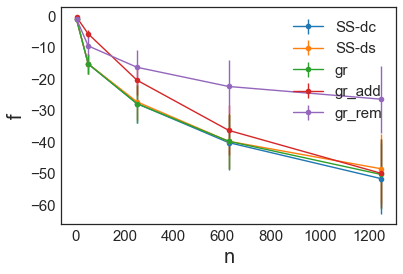

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
pal = sns.color_palette()
for c, al in zip(pal, sorted(set(df['algorithm']))):
#     if al != 'gr_rem':
#         continue
    df_ = df[df['algorithm'] == al]
    means = [np.mean(df_[df_['n'] == n]['obj']) for n in ns]
    stds = [np.std(df_[df_['n'] == n]['obj']) for n in ns]
    maxes = [np.max(df_[df_['n'] == n]['obj']) for n in ns]
    mins = [np.min(df_[df_['n'] == n]['obj']) for n in ns]
#     _ = ax.plot(ns, mins, color=c)
    _ = ax.errorbar(ns, means, yerr=stds / np.sqrt(len(starts)), fmt='-o', label=al, capsize=30, color=c)
#     _ = ax.fill_between(ns, maxes, mins, color=c, alpha=0.3)
_ = ax.set_xlabel('n')
_ = ax.set_ylabel('f')
_ = ax.legend()

In [20]:
results = {
    'df':df,
    'ds_list': ds_list,
    'dc_list': dc_list
}

with open('../outputs/20181003_synthetic_opt.pkl', 'wb') as f:
    pickle.dump(results, f)

In [45]:
np.random.seed(0)
M = [[int(np.random.random() * 26 + 1) for _ in range(L)] for _ in range(15)]
inds = [[np.random.choice(n_aas, m, replace=False) * L + i for i, m in enumerate(mm)] for mm in M]
inds = [list(itertools.chain.from_iterable(ind)) for ind in inds]
libs = [[ground[i] for i in lib] for lib in inds]
starts += libs

In [46]:
%%time
for n in ns:
    for S in starts[5:]:
        _, objs = opt.greedy(ground, S, objectives.objective, obj_args=(L, dic, n))
        other = pd.DataFrame([[n, S, L, 'gr', objs[-1]]], columns=df.columns)
        df = df.append(other)
        
for n in ns:
    for S in starts[5:]:
        _, objs = opt.greedy_add(ground, S, objectives.objective, obj_args=(L, dic, n))
        other = pd.DataFrame([[n, S, L, 'gr_add', objs[-1]]], columns=df.columns)
        df = df.append(other)
        

for n in ns:
    for S in starts[5:]:
        _, objs = opt.greedy_add(ground, S, objectives.objective, obj_args=(L, dic, n), remove=True)
        other = pd.DataFrame([[n, S, L, 'gr_rem', objs[-1]]], columns=df.columns)
        df = df.append(other)

CPU times: user 43.9 s, sys: 211 ms, total: 44.1 s
Wall time: 45.6 s


In [47]:
%%time
opt = importlib.reload(opt)
dc_list = []

for alpha, n in zip(alphas, ns):
    print(n)
    for S in starts[5:]:
        X_list, objs = opt.mod_mod(ground, S, objectives.objective, args=(L, dic, n), dec='dc', alpha=alpha,
                            beta=beta, verbose=False)
        other = pd.DataFrame([[n, S, L, 'SS-dc', objs[-1]]], columns=df.columns)
        df = df.append(other)
        dc_list.append([S, X_list, n, alpha])

2
50
250
626
1250
CPU times: user 17min 50s, sys: 1min 33s, total: 19min 24s
Wall time: 1h 32min 6s


In [48]:
%%time
opt = importlib.reload(opt)
ds_list = []

for alpha, n in zip(alphas2, ns):
    print(n)
    for S in starts[5:]:
        X_list, objs = opt.mod_mod(ground, S, objectives.objective, args=(L, dic, n), dec='dc', alpha=alpha,
                            beta=beta, verbose=False)
        other = pd.DataFrame([[n, S, L, 'SS-ds', objs[-1]]], columns=df.columns)
        df = df.append(other)
        ds_list.append([S, X_list, n, alpha])

2
50
250
626
1250
CPU times: user 32min 42s, sys: 2min 33s, total: 35min 16s
Wall time: 3h 11min 49s


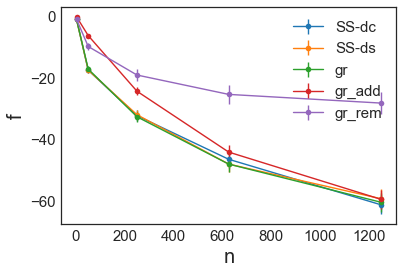

In [49]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
pal = sns.color_palette()
for c, al in zip(pal, sorted(set(df['algorithm']))):
#     if al != 'gr_rem':
#         continue
    df_ = df[df['algorithm'] == al]
    means = [np.mean(df_[df_['n'] == n]['obj']) for n in ns]
    stds = [np.std(df_[df_['n'] == n]['obj']) for n in ns]
    maxes = [np.max(df_[df_['n'] == n]['obj']) for n in ns]
    mins = [np.min(df_[df_['n'] == n]['obj']) for n in ns]
#     _ = ax.plot(ns, mins, color=c)
    _ = ax.errorbar(ns, means, yerr=stds / np.sqrt(len(starts)), fmt='-o', label=al, capsize=30, color=c)
#     _ = ax.fill_between(ns, maxes, mins, color=c, alpha=0.3)
_ = ax.set_xlabel('n')
_ = ax.set_ylabel('f')
_ = ax.legend()

In [50]:
results = {
    'df':df,
    'ds_list': ds_list,
    'dc_list': dc_list
}

with open('../outputs/20181003_synthetic_opt_extended.pkl', 'wb') as f:
    pickle.dump(results, f)

In [53]:
# Fix the SS vs MM
to_replace = ['SS-dc', 'SS-ds', 'gr', 'gr_add', 'gr_rem']
values = ['LBDC', 'LBDS', 'greedy', 'add', 'rem']
df['algorithm'] = df['algorithm'].replace(to_replace=to_replace, value=values)

In [55]:
results = {
    'df':df,
    'ds_list': ds_list,
    'dc_list': dc_list
}

with open('../outputs/20181003_synthetic_opt_extended.pkl', 'wb') as f:
    pickle.dump(results, f)

In [4]:
with open('../outputs/20181003_synthetic_opt_extended.pkl', 'rb') as f:
    results = pickle.load(f)
df = results['df']

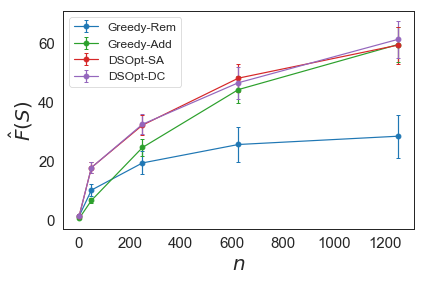

In [15]:
fig, ax = plt.subplots(1, 1)
pal = sns.color_palette()
lab_dict = {
    'greedy': 'Greedy',
    'add': 'Greedy-Add', 
    'rem': 'Greedy-Rem',
    'LBDS': 'DSOpt-SA',
    'LBDC': 'DSOpt-DC'
}
for c, al in zip(pal, sorted(set(df['algorithm']))[::-1]):
    if al == 'greedy':
        continue
    df_ = df[df['algorithm'] == al]
    means = [np.mean(df_[df_['n'] == n]['obj']) for n in ns]
    stds = [np.std(df_[df_['n'] == n]['obj']) for n in ns]
    maxes = [np.max(df_[df_['n'] == n]['obj']) for n in ns]
    mins = [np.min(df_[df_['n'] == n]['obj']) for n in ns]
#     _ = ax.plot(ns, mins, color=c)
    _ = ax.errorbar(ns, -np.array(means), yerr=stds / np.sqrt(len(starts)), fmt='-o', 
                    label=lab_dict[al], capsize=2, color=c)
#     _ = ax.fill_between(ns, maxes, mins, color=c, alpha=0.3)
_ = ax.set_xlabel(r'$n$')
_ = ax.set_ylabel(r'$\hat{F}(S)$')
_ = ax.legend()
_ = fig.tight_layout()
_ = fig.savefig('../outputs/synthetic_objectives2_no_greedy.pdf')

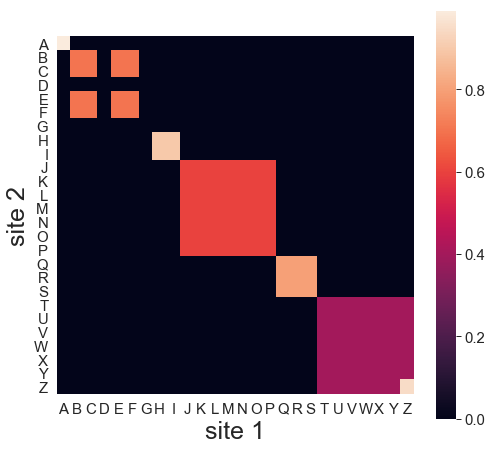

In [10]:
vals = pd.DataFrame(index=list(aas), columns=list(aas))
plt.rcParams.update({'axes.labelsize': 25})


fig, ax = plt.subplots(1, 1, figsize=(8, 7.5))

for k, v in dic.items():
    vals.loc[k[0], k[1]] = v.item()
    
vals = vals.astype('float64')
    
_ = sns.heatmap(vals, square=True, xticklabels=list(aas), yticklabels=list(aas))
_ = ax.set_xlabel('site 1')
_ = ax.set_ylabel('site 2')
_ = fig.savefig('../outputs/synthetic_heatmap2.pdf')